# CNN-LD-TF Visualization

Script for visualization

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.manifold import TSNE
from collections import Counter

import os, re
import util
import cnn

import matplotlib
matplotlib.rc('font', **{'family' : 'Arial Unicode MS'})
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.patches as mpatches

%matplotlib inline

Parameters

In [2]:
data_dir = os.path.join(os.getcwd(), 'data', 'ted500')
train_dir = os.path.join(os.getcwd(), 'model', 'ted500')
restore_params = util.load_from_dump(os.path.join(data_dir, 'preprocess3.pkl'))
config = util.load_from_dump(os.path.join(train_dir, 'flags3.pkl'))

## Visualize embeddings

In [3]:
with tf.Graph().as_default():
    with tf.variable_scope('cnn'):
        m = cnn.Model(config, is_train=False)
    saver = tf.train.Saver(tf.global_variables())

    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state(os.path.join(train_dir))
        saver.restore(sess, ckpt.model_checkpoint_path)

        embedding = sess.run(tf.global_variables())[0]

In [4]:
# save embedding
vocab = util.load_vocab(os.path.join(data_dir, 'vocab.txt'))
util.save_embedding(os.path.join(data_dir, 'emb.txt'), embedding, vocab)

Prepare 2-dim. embeddings data

In [5]:
norm = np.sqrt(np.sum(np.square(embedding), axis=0))
normalized_embeddings = embedding / norm
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(normalized_embeddings)

In [6]:
char = pd.read_csv(os.path.join(data_dir, 'metadata.tsv'), sep='\t', encoding='utf-8')
values = pd.DataFrame(two_d_embeddings, columns=['x', 'y'])
emb_df = pd.concat([char, values], axis=1)
emb_df.head()

,Char,Script,x,y
0,<unk>,Others,17.993200,2.258924
1,<pad>,Others,24.549311,-3.708156
2,<ws>,Others,24.375337,-3.691902
3,a,Basic Latin[g],24.416895,-3.671810
4,e,Basic Latin[g],24.375589,-3.719548


In [7]:
for name, group in emb_df.groupby('Script'):
    print '%30s %4d' % (name, len(group))

                        Arabic  109
   Arabic Presentation Forms-B   17
                      Armenian   44
                Basic Latin[g]   41
                       Bengali   69
   CJK Symbols and Punctuation   10
                      Cyrillic   43
                    Devanagari   80
           General Punctuation   14
                      Georgian   33
              Greek and Coptic   36
                      Gujarati   69
 Halfwidth and Fullwidth Forms   21
                           Han 1973
                        Hangul  634
                        Hebrew   28
                      Hiragana   68
                       Kannada   64
                      Katakana   78
                         Khmer   81
                         Latin   83
         Latin-1 Supplement[h]   44
                     Malayalam   67
                       Myanmar   65
                        Others   10
                       Sinhala   66
                         Tamil   46
                        Telu

Plot embeddings

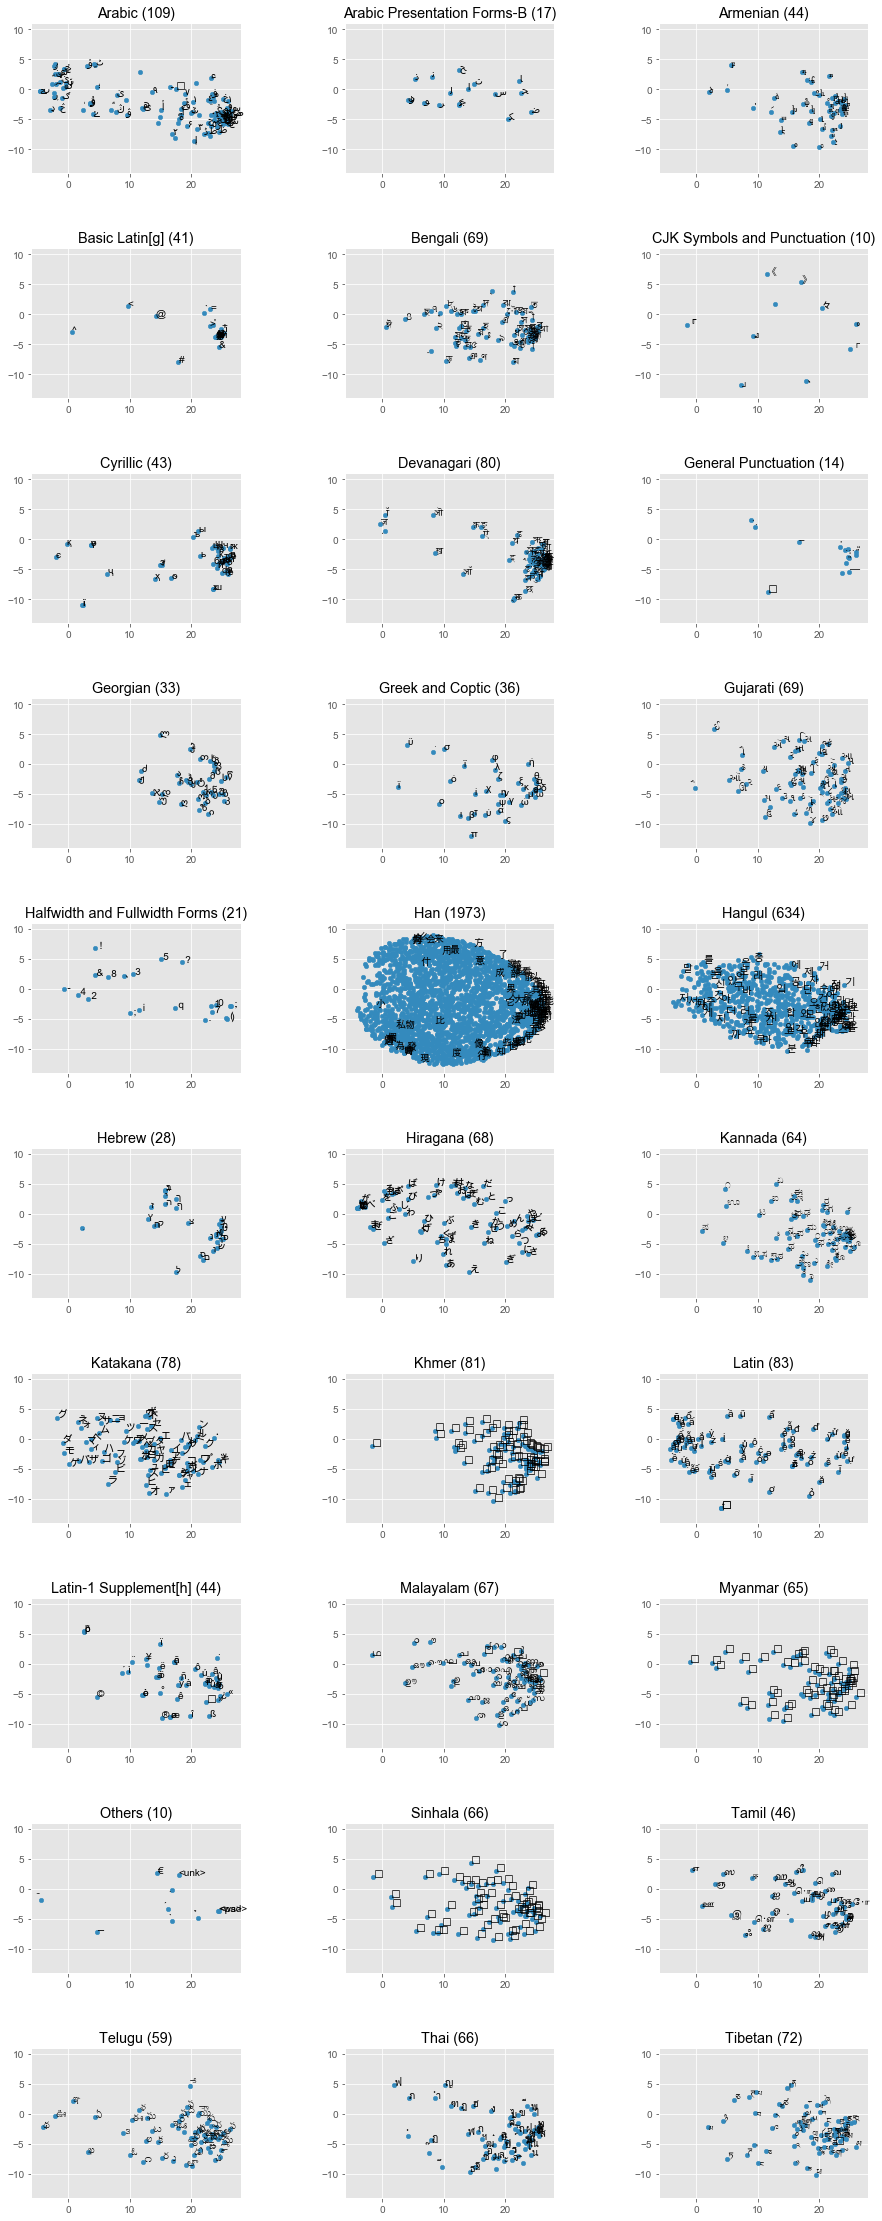

In [8]:
fig, axes = plt.subplots(10, 3, figsize=(15, 40))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i, (ax, (key, group)) in enumerate(zip(axes.flatten(), emb_df.groupby('Script'))):
    ax = group.plot(kind="scatter", x='x', y='y', ax=ax, legend=False)
    # annotate 100 labels
    for index, row in group.head(100).iterrows():
        ax.annotate(row['Char'], xy=(row['x'], row['y']))
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim(-6, 28)
    ax.set_ylim(-14, 11)
    ax.set_title('%s (%d)' % (key, len(group)))
    
fig.savefig('docs/img/embeddings.svg', bbox_inches='tight')

## Evaluation

In [9]:
loader = util.DataLoader(data_dir, 'test3.pkl', batch_size=config['batch_size'])

Loaded target classes (length 65).
Loaded data with 3250 examples. 100 examples per batch will be used.


In [10]:
with tf.Graph().as_default():
    with tf.variable_scope('cnn'):
        m = cnn.Model(config, is_train=False)
    saver = tf.train.Saver(tf.global_variables())

    predictions = []

    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state(os.path.join(train_dir))
        saver.restore(sess, ckpt.model_checkpoint_path)

        for _ in xrange(loader.num_batch):
            x, y = loader.next_batch()
            scores = sess.run(m.scores, feed_dict={m.inputs: x, m.labels: y})
            predictions.append(scores)

In [11]:
class_names = restore_params['class_names']
labels = util.load_language_codes()

In [12]:
scores = np.vstack(tuple(predictions))
scores_sort = np.sort(scores, axis=1)
scores_df = pd.DataFrame(scores)
scores_df['y_true'] = list(np.argmax(loader._y, axis=1))
scores_df['y_pred'] = list(np.argmax(scores, axis=1))
scores_df['y_best'] = [scores[i, j] for i, j in enumerate(scores_df.y_pred)]

tp = {}
fp = {}
fn = {}
avg_score = {}
avg_scores = {}

for label, group in scores_df.groupby('y_true'):
    tp[class_names[label]] = len(group[group.y_pred == label])
    fn[class_names[label]] = len(group) - tp[class_names[label]]
for label, group in scores_df.groupby('y_pred'):
    fp[class_names[label]] = len(group) - tp[class_names[label]]
    avg_score[class_names[label]] = group.y_best.mean()
    avg_scores[class_names[label]] = group[range(65)].mean().to_dict()

Plot distribution

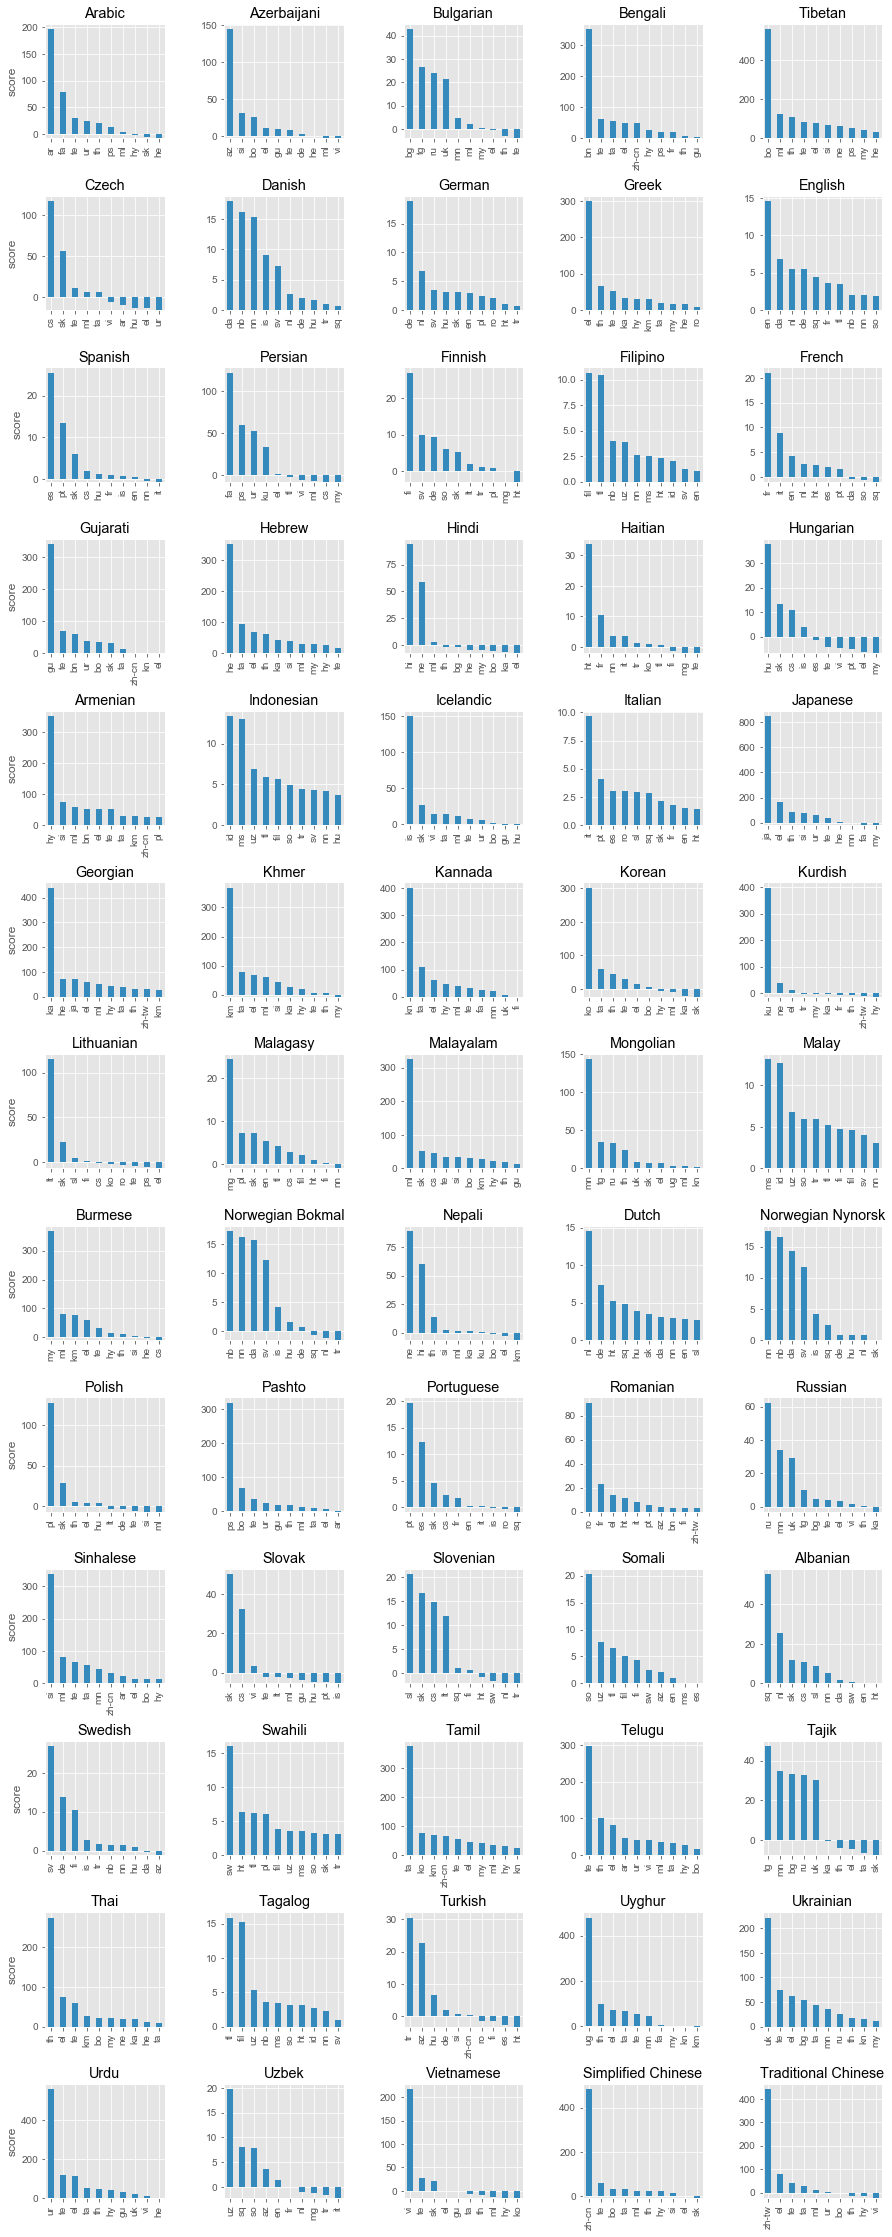

In [13]:
avg_scores_df = pd.DataFrame(avg_scores)

fig, axes = plt.subplots(13, 5, figsize=(15, 40))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for j, (ax, col) in enumerate(zip(axes.flatten(), avg_scores_df.columns)):
    top_k_df = avg_scores_df[[col]].sort_values(by=col, ascending=0).head(10)
    top_k_df['x'] = [class_names[i] for i in top_k_df.index]

    ax = top_k_df.plot(x='x', kind='bar', ax=ax, title=labels[col], color='#348abd', legend=False)
    if j % 5 == 0:
        ax.set_ylabel('score')
    ax.set_xlabel('')

fig.savefig('docs/img/score_distribution.svg', bbox_inches='tight')

Best 25

In [14]:
dic = {'precision': [float(tp[c]) / (tp[c] + fp[c]) for c in class_names],
       'recall': [float(tp[c]) / (tp[c] + fn[c]) for c in class_names],
       'avg_score': [avg_score[c] for c in class_names]}
eval_df = pd.DataFrame(dic, index=class_names)
eval_df['f1'] = 2 * (eval_df['precision'] * eval_df['recall']) / (eval_df['precision'] + eval_df['recall'])

def report(df, limit=25):
    print '{:>20} {:>12} {:>12} {:>12} {:>12}\n'.format('', 'avg. score', 'precision', 'recall', 'f1-score')
    for code, row in df.head(25).iterrows():
        string = '{:>20} {:>12.3f} {:>12.3f} {:>12.3f} {:>12.3f}'
        print string.format(labels[code], row.avg_score, row.precision, row.recall, row.f1)
report(eval_df.sort_values(by=['f1', 'avg_score'], ascending=[False, False]))

                       avg. score    precision       recall     f1-score

            Japanese      848.343        1.000        1.000        1.000
             Tibetan      554.680        1.000        1.000        1.000
              Uyghur      478.730        1.000        1.000        1.000
            Georgian      439.311        1.000        1.000        1.000
             Kannada      401.166        1.000        1.000        1.000
             Kurdish      396.903        1.000        1.000        1.000
               Khmer      367.563        1.000        1.000        1.000
             Burmese      367.033        1.000        1.000        1.000
            Armenian      352.308        1.000        1.000        1.000
              Hebrew      351.594        1.000        1.000        1.000
             Bengali      349.363        1.000        1.000        1.000
            Gujarati      340.488        1.000        1.000        1.000
           Sinhalese      337.236        1.000    

Worst 25

In [15]:
report(eval_df.sort_values(by=['f1', 'avg_score'], ascending=[True, True]))

                       avg. score    precision       recall     f1-score

            Filipino       10.678        0.536        0.300        0.385
   Norwegian Nynorsk       17.498        0.645        0.400        0.494
               Malay       13.117        0.491        0.560        0.523
          Indonesian       13.403        0.531        0.520        0.525
    Norwegian Bokmal       17.245        0.420        0.740        0.536
             Tagalog       15.866        0.479        0.700        0.569
              Danish       17.940        0.667        0.560        0.609
              Slovak       49.829        0.672        0.820        0.739
          Portuguese       19.721        0.683        0.820        0.745
             Italian        9.668        0.657        0.880        0.752
               Dutch       14.530        0.787        0.740        0.763
           Slovenian       20.605        0.698        0.880        0.779
             Spanish       25.479        0.919    

In [16]:
sort = eval_df.sort_values(by=['f1', 'avg_score'], ascending=[False, False])
print '{:>6} {:>12} {:>12} {:>12} {:>12}\n'.format('', 'avg. score', 'precision', 'recall', 'f1-score')
for i in range(5, 65, 10):
    mean = sort.head(i).mean()
    string = 'top {:>2d} {:>12.3f} {:>12.3f} {:>12.3f} {:>12.3f}'
    print string.format(i, mean.avg_score, mean.precision, mean.recall, mean.f1)
mean = eval_df.mean()
string = '{:>6} {:>12.3f} {:>12.3f} {:>12.3f} {:>12.3f}'
print string.format('all', mean.avg_score, mean.precision, mean.recall, mean.f1)

         avg. score    precision       recall     f1-score

top  5      544.446        1.000        1.000        1.000
top 15      414.084        1.000        1.000        1.000
top 25      361.478        0.997        0.990        0.994
top 35      280.138        0.984        0.977        0.980
top 45      242.756        0.969        0.959        0.963
top 55      211.742        0.952        0.931        0.939
   all      182.012        0.895        0.884        0.885


Distribution of false-positives

In [17]:
y_true = [class_names[c] for c in scores_df.y_true]
y_pred = [class_names[c] for c in scores_df.y_pred]

counter = {}
for code in class_names:
    c = Counter([a for a, b in zip(y_true, y_pred) if b == code])
    if len(c) > 1:
        counter[code] = c

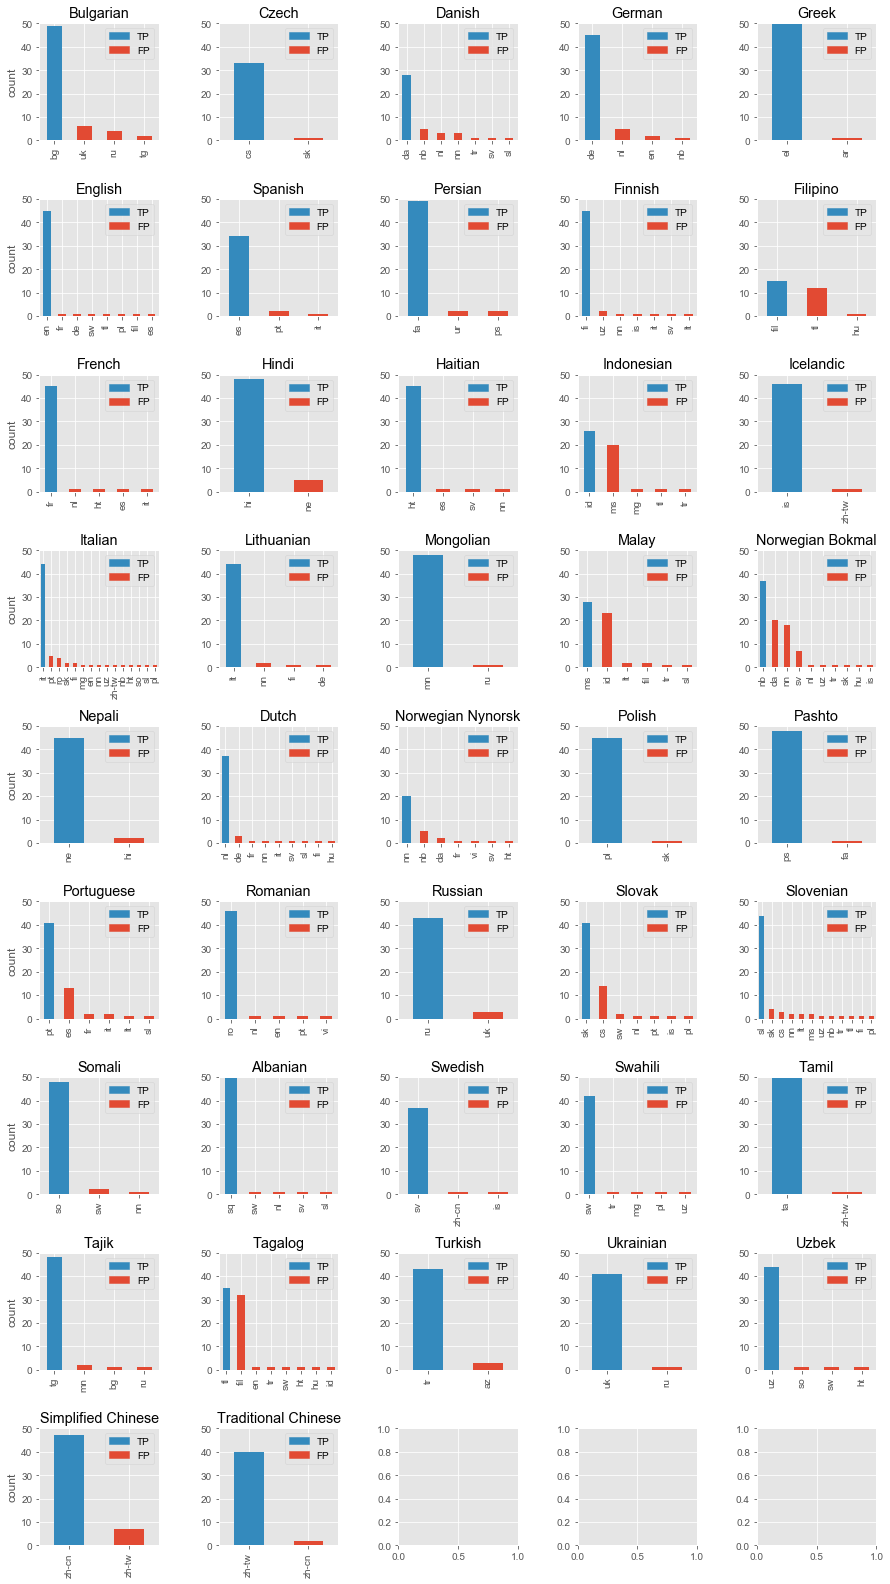

In [18]:
fig, axes = plt.subplots(9, 5, figsize=(15, 28))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for j, (ax, c) in enumerate(zip(axes.flatten(), sorted(counter.items(), key=lambda x: x[0]))):
    fp_df = pd.DataFrame(c[1].most_common(50), columns=['x', 'y']).sort_values(by='y', ascending=0)
    colors = ['#E24A33'] * len(fp_df)
    idx = fp_df[fp_df.x == c[0]].index.values[0]
    if idx >= 0:
        colors[int(idx)] = '#348ABD'
    ax = fp_df.plot(x='x', kind='bar', color=colors, legend=False, ax=ax, title=labels[c[0]])
    ax.set_label('TP')
    ax.set_ylim(0, 50)
    ax.set_xlabel('')
    tp_patch = mpatches.Patch(color='#E24A33', label='FP')
    fp_patch = mpatches.Patch(color='#348ABD', label='TP')
    ax.legend(handles=[fp_patch, tp_patch], loc='upper right')
    if j % 5 == 0:
        ax.set_ylabel('count')
        
fig.savefig('docs/img/fp_distribution.svg', bbox_inches='tight')

## Visualize train log

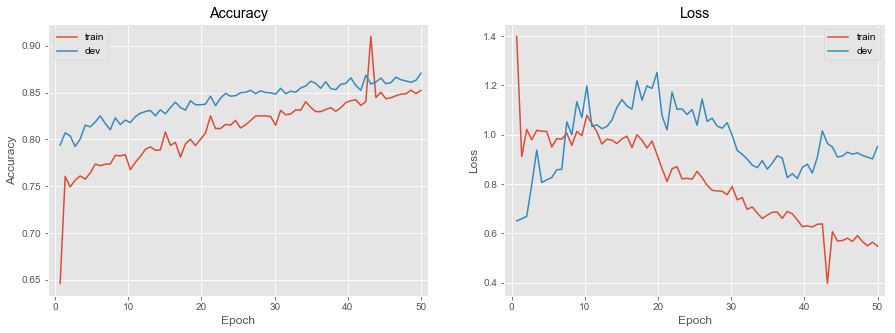

In [19]:
train_acc = pd.read_csv(os.path.join(train_dir, 'summaries', 'train-accuracy.csv'),
                        index_col=1, names=['time', 'train'], skiprows=[0])
dev_acc = pd.read_csv(os.path.join(train_dir, 'summaries', 'dev-accuracy.csv'), 
                      index_col=1, names=['time', 'dev'], skiprows=[0])
train_loss = pd.read_csv(os.path.join(train_dir, 'summaries', 'train-loss.csv'),
                        index_col=1, names=['time', 'train'], skiprows=[0])
dev_loss = pd.read_csv(os.path.join(train_dir, 'summaries', 'dev-loss.csv'), 
                      index_col=1, names=['time', 'dev'], skiprows=[0])

num_per_epoch = max(train_acc.index) / float(config['num_epoch'])
train_acc.index = train_acc.index / num_per_epoch
train_loss.index = train_loss.index / num_per_epoch
dev_acc.index = dev_acc.index / num_per_epoch
dev_loss.index = dev_loss.index / num_per_epoch

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_acc_mask = np.isfinite(train_acc['train'])
dev_acc_mask = np.isfinite(dev_acc['dev'])
ax1 = train_acc['train'][train_acc_mask].plot(legend=True, ax=axes[0])
ax1 = dev_acc['dev'][dev_acc_mask].plot(legend=True, title="Accuracy", ax=ax1)
ax1.set_xlim(-1, config['num_epoch']+1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')

train_loss_mask = np.isfinite(train_loss['train'])
dev_loss_mask = np.isfinite(dev_loss['dev'])
ax2 = train_loss['train'][train_loss_mask].plot(legend=True, ax=axes[1])
ax2 = dev_loss['dev'][dev_loss_mask].plot(legend=True, title="Loss", ax=ax2)
ax2.set_xlim(-1, config['num_epoch']+1)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
    
fig.savefig('docs/img/learning_curves.svg', bbox_inches='tight')

## TODO

What's next?
+ basline system with extracted features (instead of character embeddings)
+ parameter calibration
+ more examples for critical pairs (such as es-pr, ms-id, nn-nb) ???